In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(19753, 28)
(19753, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FR is swinging
idxs = np.where(X_motion[:, 22] == 1)[0]
X_motion_FR_swinging = X_motion[idxs]
Y_motion_FR_swinging = Y_motion[idxs]

## Predict FR foot -> x

In [8]:
X_motion_FR_swinging[0, :]

array([ 1.00000001e-01,  0.00000000e+00,  0.00000000e+00, -6.76389665e-02,
       -5.28462911e-02, -7.50896044e-03,  1.37157175e-03, -4.14305433e-03,
       -1.59415558e-02, -7.73945235e-02, -4.06116918e-01,  3.04750451e-04,
       -3.86529746e-01,  2.03541754e-02, -4.54600232e-04,  4.14702722e-01,
       -2.55079578e-02,  2.65283941e-04,  4.06443912e-02,  3.90287455e-01,
       -1.15434161e-04,  0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  1.00000001e-01,  0.00000000e+00,  0.00000000e+00])

In [9]:
Y_motion_FR_swinging[0, :]

array([0.03783798, 0.00053955, 0.03814759, 0.00010739])

### Linear Regression

In [10]:
# Input
X = np.hstack((X_motion_FR_swinging[:, :3], # prev velocity command
               X_motion_FR_swinging[:, -3:], # commanded velocity command
               X_motion_FR_swinging[:, 3:9],
               X_motion_FR_swinging[:, 9:11], # FL (x,y) position
               X_motion_FR_swinging[:, 12:14], # FR (x,y) position
               X_motion_FR_swinging[:, 15:17], # RL (x,y) position
               X_motion_FR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_FR_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_relative_swinging_x = LinearRegression()

# Fit the model
model_fr_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9448754772411746
RMSE:  0.017522560009443106
The lowest error is:  2.7507161123957458e-05
The highest error is:  0.12407555643287482
The avg. error is:  0.012368668347706443


In [11]:
model_fr_relative_swinging_x.coef_

array([[-0.01012625, -0.05333315,  0.08575225,  0.25018434, -0.03103397,
         0.00848476,  0.06932404, -0.14961675,  0.0182475 ,  0.22954765,
         0.19683697, -0.06911275, -0.1846065 ,  0.65521718,  0.21630495,
         0.18183266,  0.14258274,  0.18210261, -0.19212241,  0.73537638]])

In [12]:
model_fr_relative_swinging_x.intercept_

array([0.13249902])

Text(0, 0.5, 'Predictions')

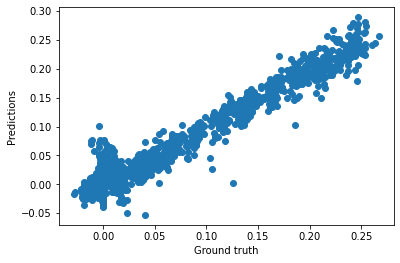

In [12]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [14]:
#%store model_fr_relative_swinging_x

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [16]:
# Save model
#joblib.dump(model_fr_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_x.sav")

### Predict FL foot -> y

In [16]:
# Input
X = np.hstack((X_motion_FR_swinging[:, :3], # prev velocity command
               X_motion_FR_swinging[:, -3:], # commanded velocity command
               X_motion_FR_swinging[:, 3:9],
               X_motion_FR_swinging[:, 9:11], # FL (x,y) position
               X_motion_FR_swinging[:, 12:14], # FR (x,y) position
               X_motion_FR_swinging[:, 15:17], # RL (x,y) position
               X_motion_FR_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_FR_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_relative_swinging_y = LinearRegression()

# Fit the model
model_fr_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9091252464518147
RMSE:  0.013535906975147803
The lowest error is:  4.164551854802818e-06
The highest error is:  0.14731826708678067
The avg. error is:  0.008639756550743026


In [17]:
model_fr_relative_swinging_y.coef_

array([[-1.92790268e-02, -8.44765893e-03, -3.29994904e-02,
        -3.69226941e-04,  2.27983385e-01, -2.15071618e-02,
         5.30934353e-02,  4.30829639e-03,  7.55640736e-02,
         6.79236893e-02,  1.34599522e-01, -2.88588348e-02,
        -6.95632341e-02, -3.95524029e-01,  1.92878172e-01,
        -9.45800737e-02,  1.24288387e-01, -1.32228356e-01,
        -8.41168550e-02, -3.43558842e-01]])

In [18]:
model_fr_relative_swinging_y.intercept_

array([0.00165518])

Text(0, 0.5, 'Predictions')

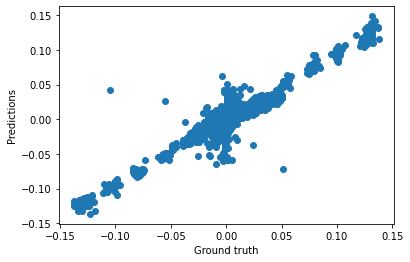

In [19]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [21]:
#%store model_fr_relative_swinging_y

In [36]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [37]:
# Save model
#joblib.dump(model_fr_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fr_relative_swinging_y.sav")